In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import pandas as pd
import scipy.stats
import tensorflow as tf
import tensorflow_probability as tfp
import scanpy as sc

print()
print("numpy version "+np.__version__)
print("tensorflow version "+tf.__version__)
print("tensorflow_probability version "+tfp.__version__)


import batchglm.api as glm
import diffxpy.api as de

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)

/Users/derekbogdanoff/miniconda3/envs/diffxpy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/derekbogdanoff/miniconda3/envs/diffxpy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/derekbogdanoff/miniconda3/envs/diffxpy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/derekb


numpy version 1.17.3
tensorflow version 1.14.0
tensorflow_probability version 0.7.0
batchglm version v0.6.8
diffpy version v0.6.13


# load annotated data

In [3]:
annot = sc.read_h5ad('/Users/derekbogdanoff/projects/XYZeq/new_h5s/Processed_Liver_All_Batches_mouse_deconV2_spatial.h5ad')

In [4]:
adata_matrix = sc.read_h5ad('/Users/derekbogdanoff/projects/XYZeq/new_h5s/Liver_All_Batches_mouse_deconV2_raw_counts.h5ad')

In [5]:
adata = adata_matrix[adata_matrix.obs.index.isin(annot.obs.index.to_list())]



/Users/derekbogdanoff/miniconda3/envs/diffxpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [6]:
##set annotations
adata.obs = annot.obs

adata.uns = annot.uns

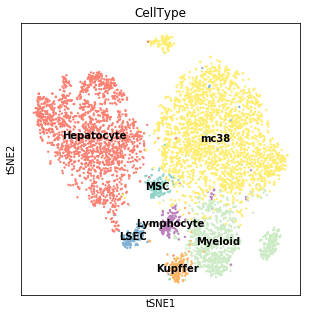

In [7]:
plt.rcParams['figure.figsize'] = [5, 5]

sc.pl.tsne(adata,
          color=['CellType'],
          legend_loc = 'on data'
          )


In [8]:
## convert float32 matrix to integers 
adata.X =  adata.X.astype(int) 

In [9]:
adata.X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
##log normalize 
adata = sc.pp.log1p(adata, copy=True)

/Users/derekbogdanoff/miniconda3/envs/diffxpy/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:284: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:


In [11]:
## name continuous variable "time" - necessary for diffxpy bug
adata.obs['time'] = adata.obs['prox_2']

In [12]:
##filter out human genes

adata = adata[:,adata.var_names.str.startswith('mm10_')]

/Users/derekbogdanoff/miniconda3/envs/diffxpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [13]:
## remove cell with nan prox_2 values
adata = adata[~adata.obs['time'].isnull()]

/Users/derekbogdanoff/miniconda3/envs/diffxpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [14]:
##create species specific matricies

adata_Myeloid = adata[adata.obs['CellType'] == 'Myeloid']

adata_lymphocyte = adata[adata.obs['CellType'] == 'Lymphocyte']

adata_hepatocyte = adata[adata.obs['CellType'] == 'Hepatocyte']

adata_mc38 = adata[adata.obs['CellType'] == 'mc38']


/Users/derekbogdanoff/miniconda3/envs/diffxpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [15]:

##reassign to fix other diffxpy bug


## name continuous variable "time" - necessary for diffxpy bug
adata_hepatocyte.obs['time'] = adata_hepatocyte.obs['prox_2']

adata_mc38.obs['time'] = adata_mc38.obs['prox_2']

adata_Myeloid.obs['time'] = adata_Myeloid.obs['prox_2']



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [16]:
### fix integer issue - after log transforming

adata_hepatocyte.X =  adata_hepatocyte.X.astype(int) 

adata_mc38.X =  adata_mc38.X.astype(int) 

adata_Myeloid.X =  adata_Myeloid.X.astype(int) 

In [17]:
adata_Myeloid.X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
det_myeloid = de.test.continuous_1d(   
    data=adata_Myeloid.X,    
    
    sample_description=adata_Myeloid.obs,
    
    gene_names=adata_Myeloid.var_names,
    
    formula_loc="~ 1 + time + batch",
    
    formula_scale="~ 1 + batch",
    
    factor_loc_totest="time",

    continuous="time",
#    size_factors=np.random.uniform(0.2, 2, adata_macrophage.n_obs),  
    df=4,
    quick_scale=False   
)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Step: 0 loss: 4762.502763 models converged 0
INFO:tensorflow:Step: 1 loss: 4705.508886, converged 12929 in 8.506 sec., updated 11751, {f: 0, g: 12929, x: 0}
INFO:tensorflow:Step: 2 loss: 4697.046466, converged 12929 in 6.771 sec., updated 7281, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 3 loss: 4693.645924, converged 12929 in 7.451 sec., updated 7360, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 4 loss: 4691.446384, converged 12929 in 7.52 sec., updated 7441, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 5 loss: 4689.800362, conver

In [20]:
### save results
det_myeloid.summary().to_csv('det_myeloid_summary.csv')
det_myeloid._continuous_interpolation()

In [23]:
det_myeloid._continuous_interpolation(idx=)

TypeError: _continuous_interpolation() missing 1 required positional argument: 'idx'

In [19]:
det_myeloid

In [ ]:
# det_hepatocyte = de.test.continuous_1d(   
#     data=adata_hepatocyte.X,    
    
#     sample_description=adata_hepatocyte.obs,
    
#     gene_names=adata_hepatocyte.var_names,
    
#     formula_loc="~ 1 + time + batch",
    
#     formula_scale="~ 1 + batch",
    
#     factor_loc_totest="time",

#     continuous="time",
# #    size_factors=np.random.uniform(0.2, 2, adata_macrophage.n_obs),  
#     df=4,
#     quick_scale=False   
# )

In [35]:
det_myeloid.summary().to_csv('det_myeloid.csv')

In [44]:
pd.Series(det_myeloid._idx_genes(genes=adata_Myeloid.var_names.tolist())).to_csv('idex_genes.csv')

In [42]:
xcoord, data = det_myeloid._continuous_interpolation(idx=det_myeloid._idx_genes(genes=adata_Myeloid.var_names.tolist()))

pd.DataFrame(data).to_csv('data.csv')

(array([0.11260208, 0.11975438, 0.12690668, 0.13405898, 0.14121128,
        0.14836358, 0.15551588, 0.16266818, 0.16982048, 0.17697279,
        0.18412509, 0.19127739, 0.19842969, 0.20558199, 0.21273429,
        0.21988659, 0.22703889, 0.23419119, 0.24134349, 0.2484958 ,
        0.2556481 , 0.2628004 , 0.2699527 , 0.277105  , 0.2842573 ,
        0.2914096 , 0.2985619 , 0.3057142 , 0.3128665 , 0.3200188 ,
        0.32717111, 0.33432341, 0.34147571, 0.34862801, 0.35578031,
        0.36293261, 0.37008491, 0.37723721, 0.38438951, 0.39154181,
        0.39869411, 0.40584642, 0.41299872, 0.42015102, 0.42730332,
        0.43445562, 0.44160792, 0.44876022, 0.45591252, 0.46306482,
        0.47021712, 0.47736942, 0.48452173, 0.49167403, 0.49882633,
        0.50597863, 0.51313093, 0.52028323, 0.52743553, 0.53458783,
        0.54174013, 0.54889243, 0.55604473, 0.56319704, 0.57034934,
        0.57750164, 0.58465394, 0.59180624, 0.59895854, 0.60611084,
        0.61326314, 0.62041544, 0.62756774, 0.63

In [2]:
#####load data summaries
det_hepatocyte_5000_summary = pd.read_csv('/Users/derekbogdanoff/Downloads/det_hepatocyte_5000.csv')
det_mc38_5000_summary = pd.read_csv('/Users/derekbogdanoff/Downloads/det_mc38_5000.csv')
det_myeloid_5000_summary = pd.read_csv('/Users/derekbogdanoff/Downloads/det_Myeloid_5000.csv')

In [3]:
#####load data summaries
det_hepatocyte_5000_data = pd.read_csv('/Users/derekbogdanoff/Downloads/data_hepatocyte_5000.csv',
                                      index_col=0)
det_mc38_5000_data = pd.read_csv('/Users/derekbogdanoff/Downloads/data_mc38_5000.csv',
                                index_col=0)
det_myeloid_5000_data = pd.read_csv('/Users/derekbogdanoff/Downloads/data_Myeloid_5000.csv',
                                   index_col=0)

In [4]:
#####load data summaries
det_hepatocyte_5000_gene_idx = pd.read_csv('/Users/derekbogdanoff/Downloads/gene_idx_hepatocyte_5000.csv')
det_mc38_5000_gene_idx = pd.read_csv('/Users/derekbogdanoff/Downloads/gene_idx_mc38_5000.csv')
det_myeloid_5000_gene_idx = pd.read_csv('/Users/derekbogdanoff/Downloads/gene_idx_Myeloid_5000.csv')

In [5]:
#qval cutoffs

gene_frame_hepatocyte = det_hepatocyte_5000_summary[det_hepatocyte_5000_summary.sort_values(
    'qval', )['qval'] <= 0.05]

gene_frame_mc38 = det_mc38_5000_summary[det_mc38_5000_summary.sort_values(
    'qval', )['qval'] <= 0.05]

gene_frame_myeloid = det_myeloid_5000_summary[det_myeloid_5000_summary.sort_values(
    'qval', )['qval'] <= 0.05]



/Users/derekbogdanoff/miniconda3/envs/diffxpy/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/derekbogdanoff/miniconda3/envs/diffxpy/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/derekbogdanoff/miniconda3/envs/diffxpy/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [6]:
#log fold change cutoff

gene_frame_hepatocyte = gene_frame_hepatocyte[gene_frame_hepatocyte.log2fc >= 2]

gene_frame_mc38 = gene_frame_mc38[gene_frame_mc38.log2fc >= 2]

gene_frame_myeloid = gene_frame_myeloid[gene_frame_myeloid.log2fc >= 2]



In [7]:
# #get gene ids in list


# gene_idx = det_myeloid._idx_genes(
    
#     genes=gene_frame_2['gene'].tolist()

# )

In [8]:
##tranform continuous data
det_hepatocyte_5000_data = det_hepatocyte_5000_data.T
det_mc38_5000_data = det_mc38_5000_data.T
det_myeloid_5000_data = det_myeloid_5000_data.T

In [9]:
det_hepatocyte_5000_data.index = det_hepatocyte_5000_summary.iloc[list(
    list(det_hepatocyte_5000_gene_idx['0']))]['gene'].str[5:]

det_mc38_5000_data.index = det_mc38_5000_summary.iloc[list(
    list(det_mc38_5000_gene_idx['0']))]['gene'].str[5:]

det_myeloid_5000_data.index = det_myeloid_5000_summary.iloc[list(
    list(det_myeloid_5000_gene_idx['0']))]['gene'].str[5:]



In [10]:
det_hepatocyte_5000_data_2 = det_hepatocyte_5000_data.div(
    det_hepatocyte_5000_data.sum(axis=1), axis=0)

det_mc38_5000_data_2 = det_mc38_5000_data.div(
    det_mc38_5000_data.sum(axis=1), axis=0)

det_myeloid_5000_data_2 = det_myeloid_5000_data.div(
    det_myeloid_5000_data.sum(axis=1), axis=0)

In [11]:
det_hepatocyte_5000_data_3=det_hepatocyte_5000_data_2[
    ~(det_hepatocyte_5000_data_2 > 0.02).any(1)]

det_mc38_5000_data_3=det_mc38_5000_data_2[
    ~(det_mc38_5000_data_2 > 0.02).any(1)]

det_myeloid_5000_data_3=det_myeloid_5000_data_2[
    ~(det_myeloid_5000_data_2 > 0.02).any(1)]

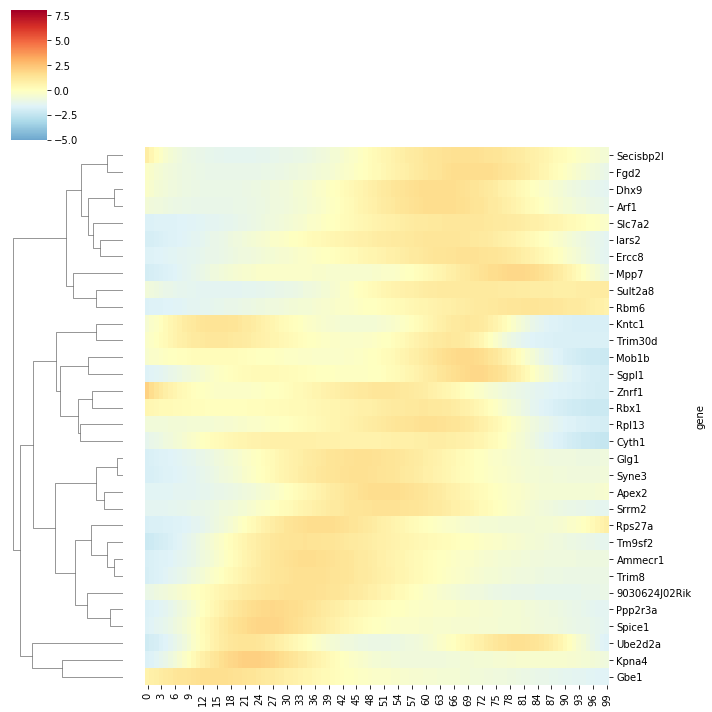

In [12]:
plt.rcParams['figure.figsize'] = [10, 20]

# z_scoreint or None, optional
# Either 0 (rows) or 1 (columns).





g =sns.clustermap(data=det_hepatocyte_5000_data_3,
             metric='cityblock', #defualt euclidean   #canberra
             method='average',
            z_score=0,
           cmap='RdYlBu_r',
            vmax=8,
            vmin=-5,
            center=0,
               col_cluster=False      
           )

#plt.savefig('/Users/derekbogdanoff/Desktop/heatmap_spatial.svg', bbox_inches='tight')



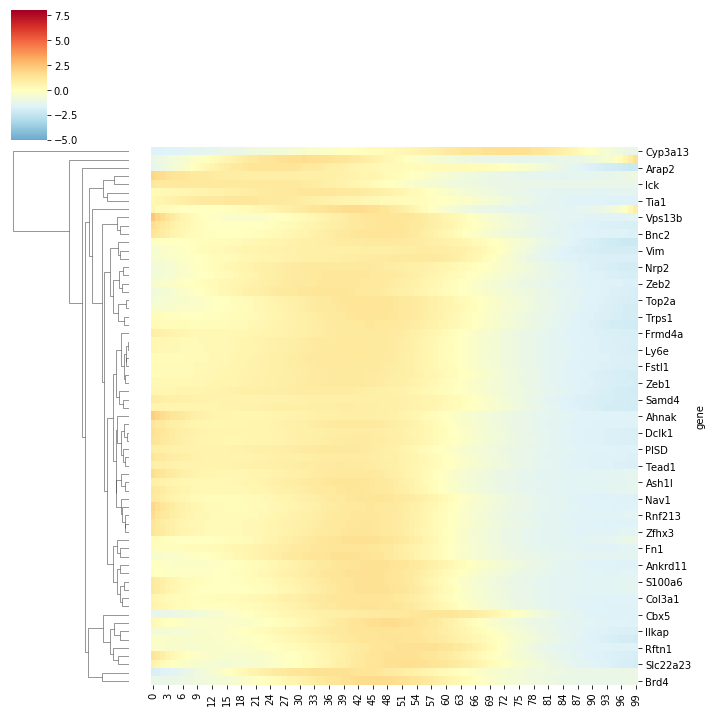

In [46]:
plt.rcParams['figure.figsize'] = [10, 20]

g =sns.clustermap(data=det_mc38_5000_data_3,
             metric='cityblock', #defualt euclidean   #canberra
             method='average',
            z_score=0,
            cmap='RdYlBu_r',
            vmax=8,
            vmin=-5,
            center=0,
               col_cluster=False      
           )

#plt.savefig('/Users/derekbogdanoff/Desktop/heatmap_spatial.svg', bbox_inches='tight')



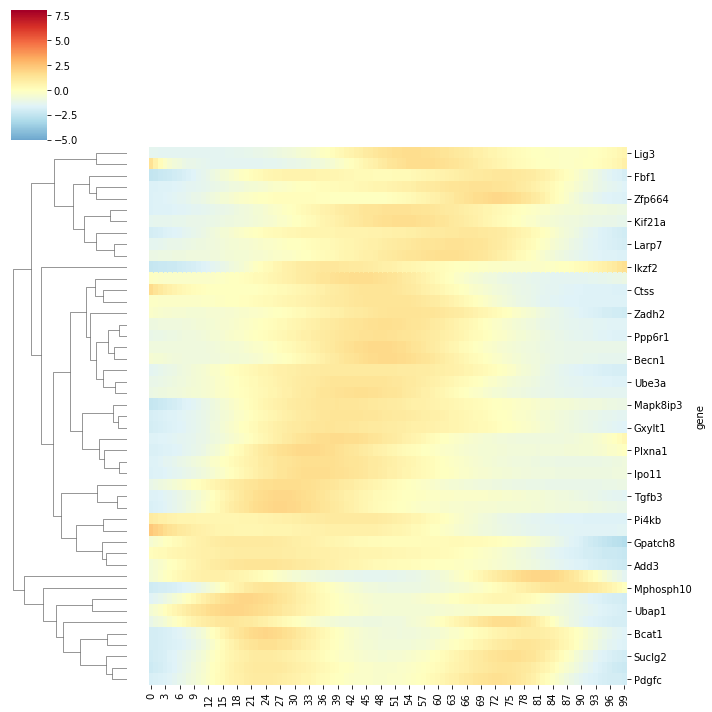

In [25]:
plt.rcParams['figure.figsize'] = [10, 20]

# z_scoreint or None, optional
# Either 0 (rows) or 1 (columns).





g =sns.clustermap(data=det_myeloid_5000_data_3,
             metric='cityblock', #defualt euclidean   #canberra
             method='average',
            z_score=0,
           cmap='RdYlBu_r',
            vmax=8,
            vmin=-5,
            center=0,
               col_cluster=False      
           )

#plt.savefig('/Users/derekbogdanoff/Desktop/heatmap_spatial.svg', bbox_inches='tight')



/Users/derekbogdanoff/miniconda3/envs/diffxpy/lib/python3.6/site-packages/seaborn/matrix.py:714: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0.0
  ax.set_xlim(0, max_dependent_coord * 1.05)


ValueError: The condensed distance matrix must contain only finite values.

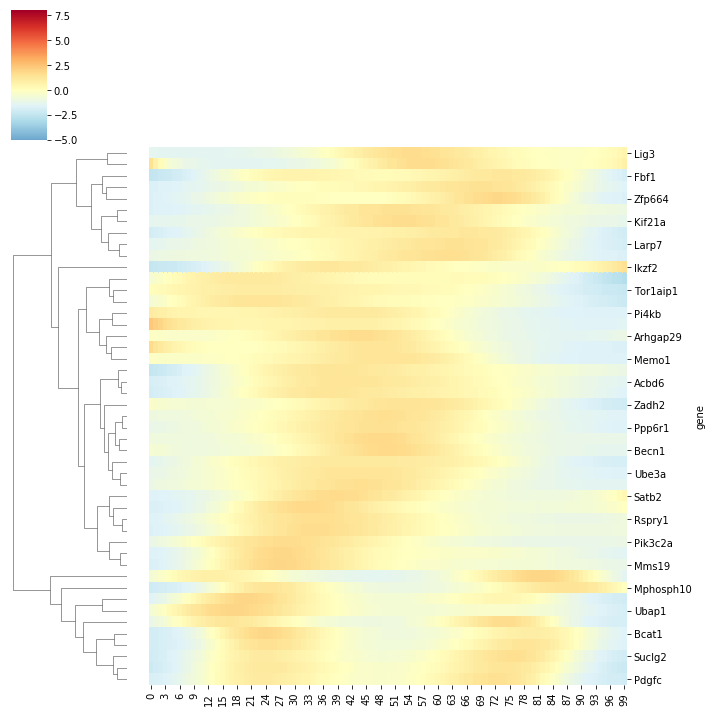

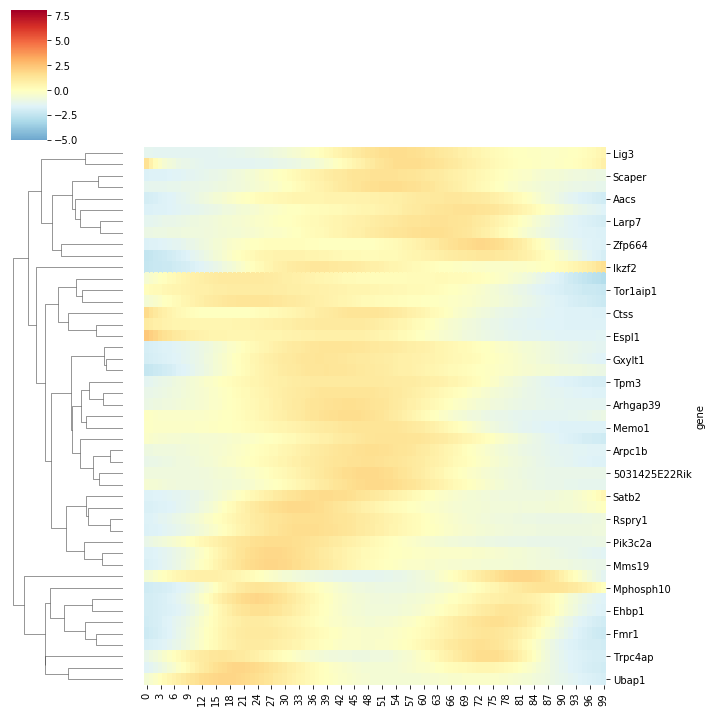

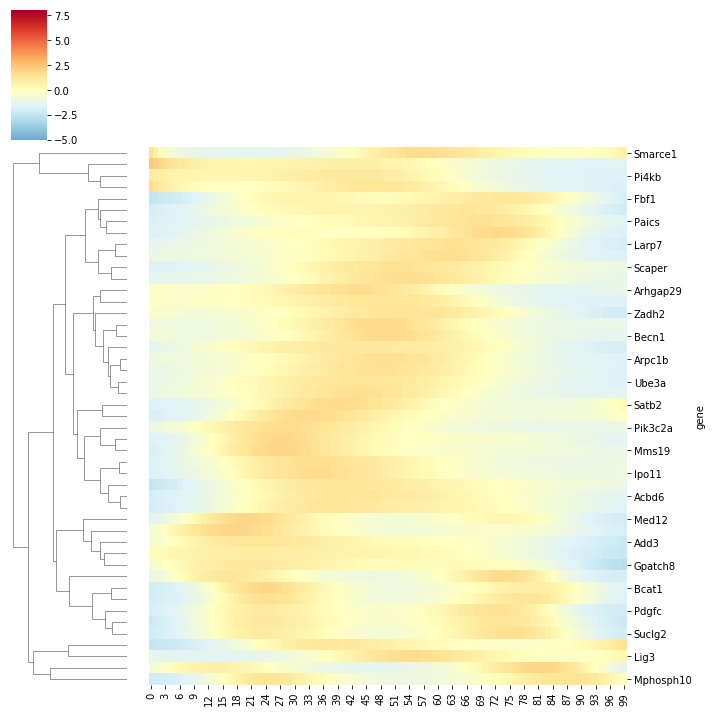

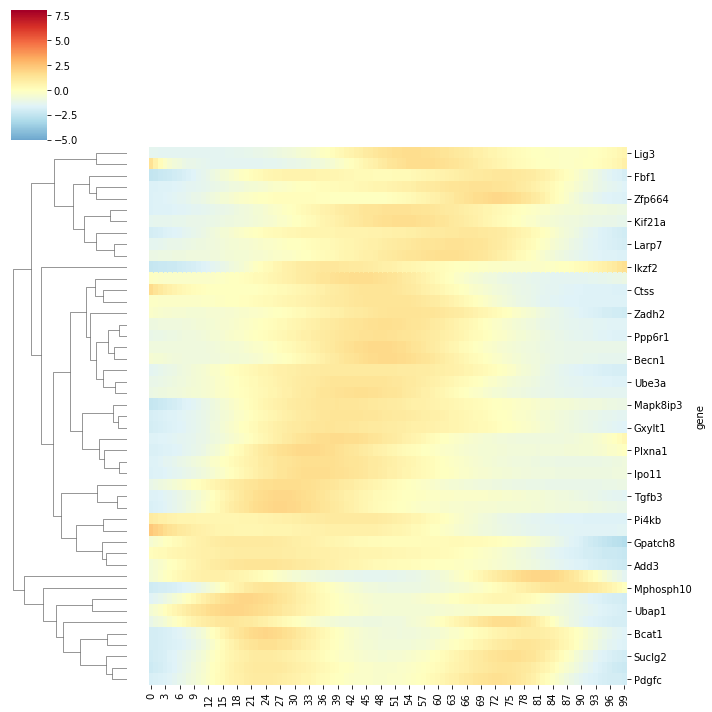

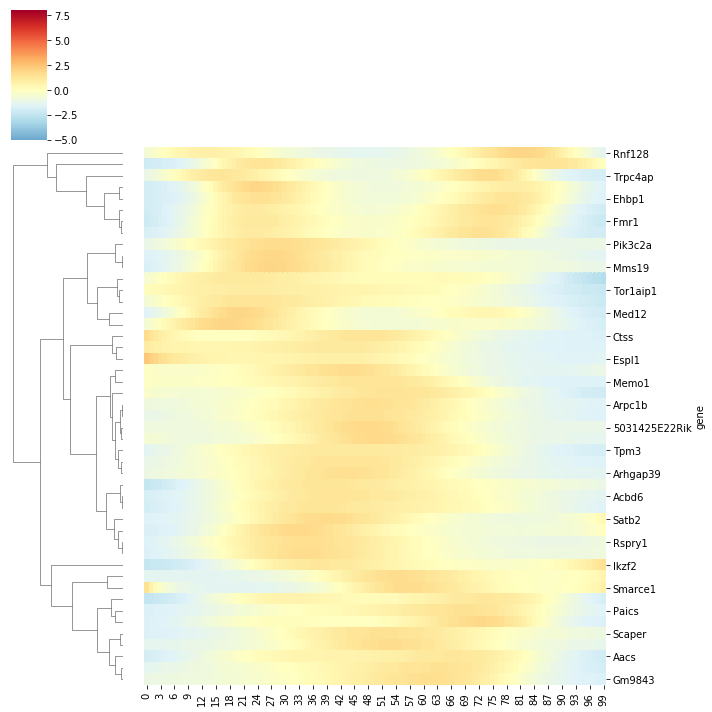

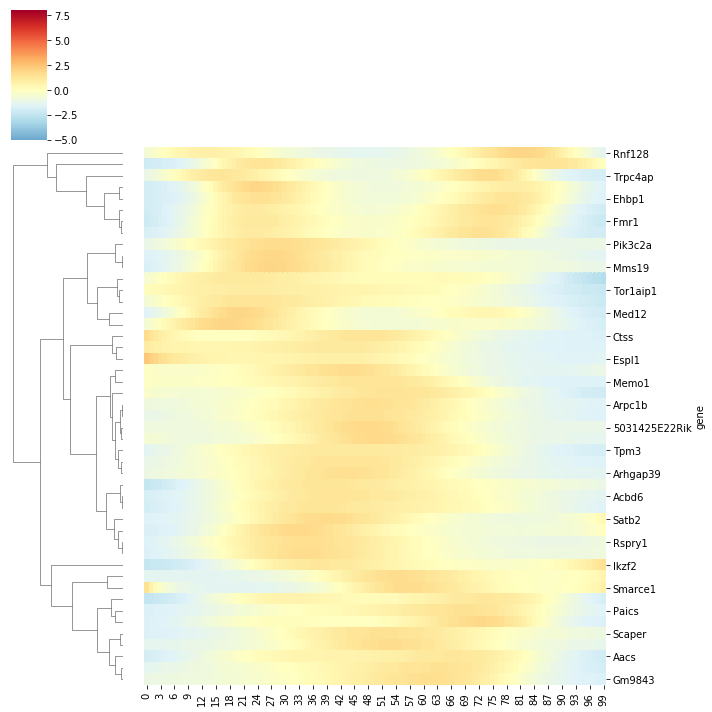

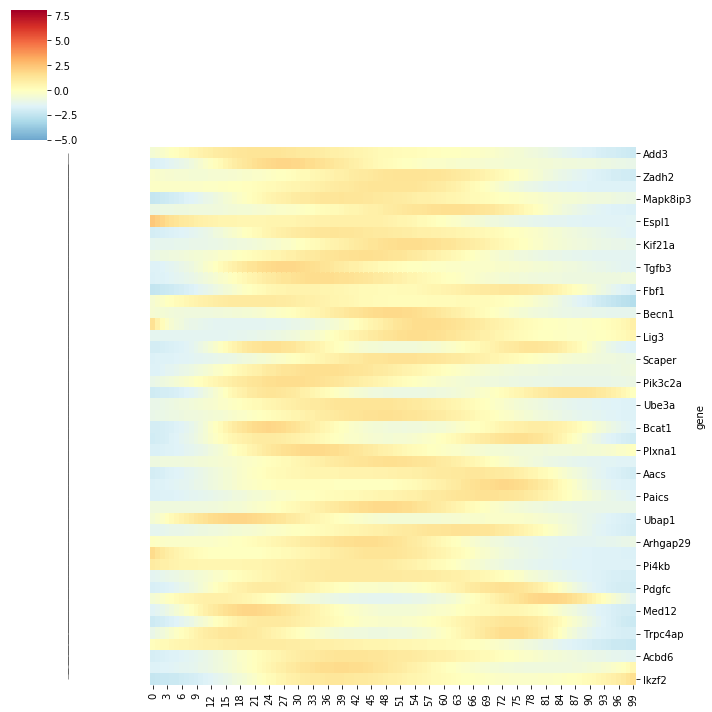

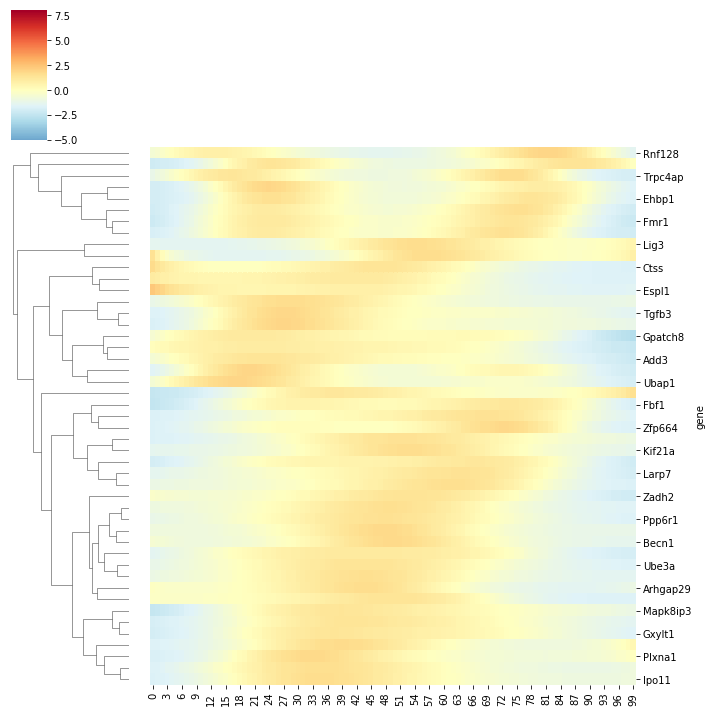

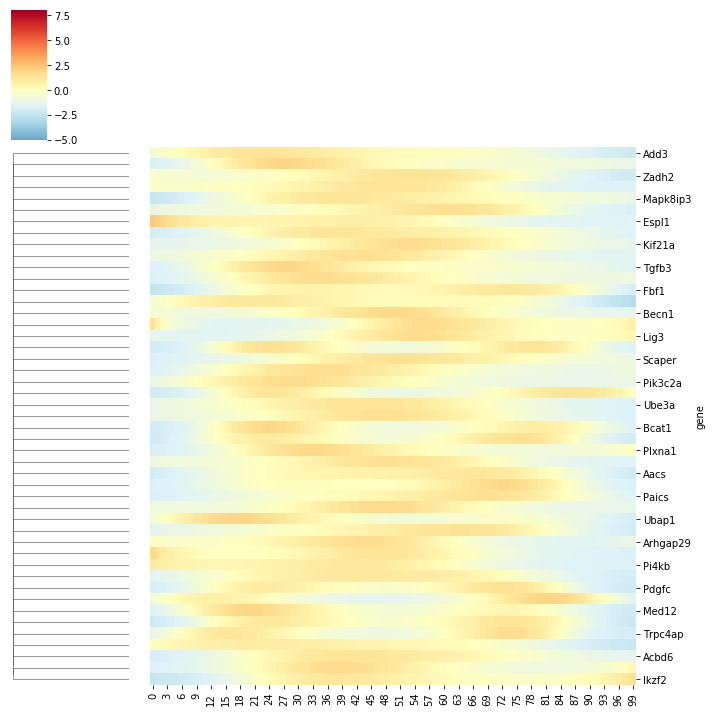

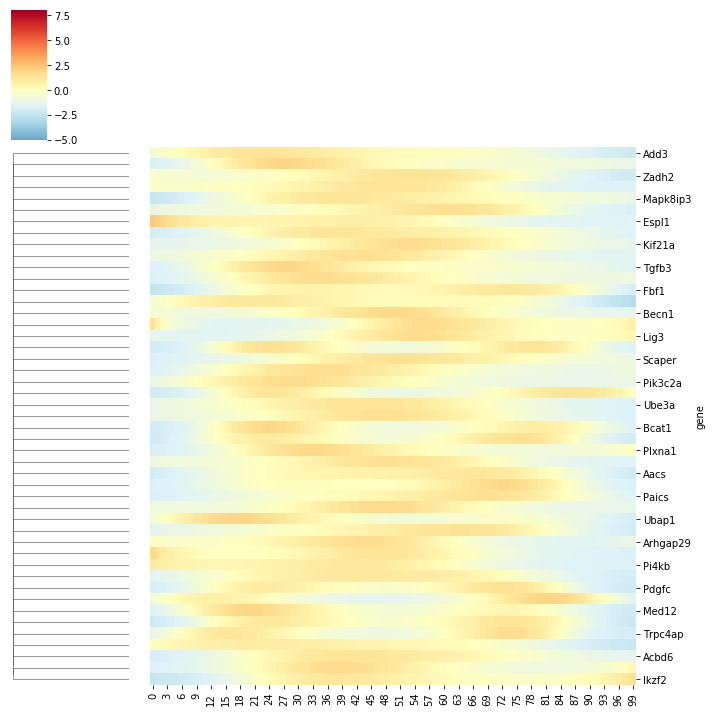

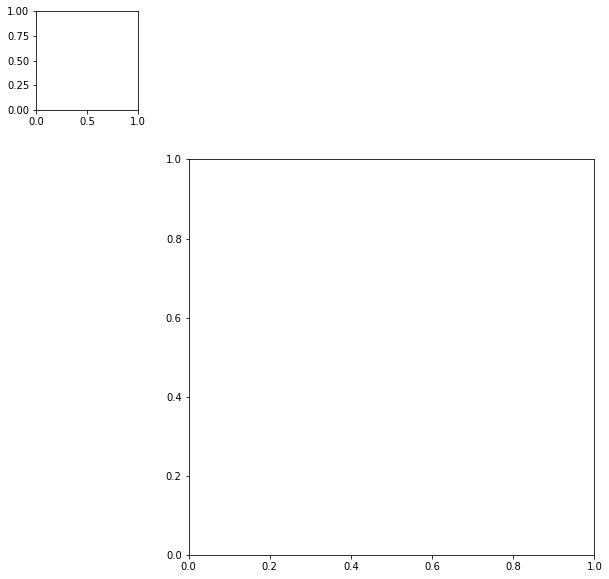

In [47]:
#screen different clustering metrics
metric = ['braycurtis', 'canberra', 'chebyshev', 'cityblock',
    'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
    'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching',
    'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
    'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

for i in metric:
    g =sns.clustermap(data=det_myeloid_5000_data_3,
             metric=i, #defualt euclidean   #canberra
             method='average',
            z_score=0,
            cmap='RdYlBu_r',
            vmax=8,
            vmin=-5,
            center=0,
            col_cluster=False      
           )
    

In [22]:
color_list = []

from pylab import *

cmap = cm.get_cmap('Set3', 20)

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    color_list.append(matplotlib.colors.rgb2hex(rgb))
    print(matplotlib.colors.rgb2hex(rgb))

#8dd3c7
#8dd3c7
#ffffb3
#ffffb3
#bebada
#fb8072
#fb8072
#80b1d3
#fdb462
#fdb462
#b3de69
#b3de69
#fccde5
#d9d9d9
#d9d9d9
#bc80bd
#ccebc5
#ccebc5
#ffed6f
#ffed6f


In [23]:
###expand colors of dendrogram link

import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy

hierarchy.set_link_color_palette(color_list)

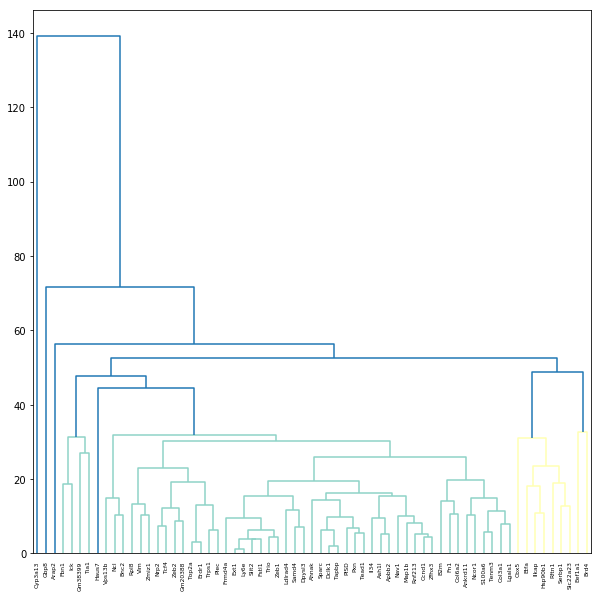

In [29]:
plt.rcParams['figure.figsize'] = [10, 10]

den = scipy.cluster.hierarchy.dendrogram(g.dendrogram_row.linkage,
                                         labels = det_mc38_5000_data_3.index,
                                         color_threshold=40)  



In [30]:
from collections import defaultdict

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

In [32]:
clusters = get_cluster_classes(den)

cluster = []
for i in det_mc38_5000_data_3.index:
    included=False
    for j in clusters.keys():
        if i in clusters[j]:
            cluster.append(j)
            included=True
    if not included:
        cluster.append(None)

# df["cluster"] = cluster

In [33]:
len(clusters.keys()) # ['#8000ff']

3

In [34]:
valuesA = []


for key, value in clusters.items():
    for indexx in value:
        temp = [indexx, key]
        valuesA.append(temp)

In [35]:
index_color = pd.DataFrame(np.matrix(valuesA))
index_color.columns=['indices', 'color']

array(['#8dd3c7', 'C0', '#ffffb3'], dtype=object)

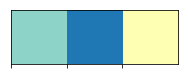

In [36]:
sns.palplot(index_color['color'].unique())
index_color['color'].unique()

In [38]:
group_0 =det_mc38_5000_data_3[det_mc38_5000_data_3.index.isin(clusters['C0'])].index.tolist()
group_1 =det_mc38_5000_data_3[det_mc38_5000_data_3.index.isin(clusters['#8dd3c7'])].index.tolist()
group_2 =det_mc38_5000_data_3[det_mc38_5000_data_3.index.isin(clusters['#ffffb3'])].index.tolist()


In [39]:
from gprofiler import GProfiler



In [41]:
gp = GProfiler(return_dataframe=True)
gp.profile(organism='mmusculus',
            query=group_0
          )

In [ ]:
gp = GProfiler(return_dataframe=True)
gp.profile(organism='mmusculus',
            query=group_1
          )

In [ ]:
gp = GProfiler(return_dataframe=True)
gp.profile(organism='mmusculus',
            query=group_3
          )